In [1]:
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
)
import json
import time 
from transformers.modeling_attn_mask_utils import _prepare_4d_causal_attention_mask
from torch.utils.data import DataLoader

In [2]:
model_name = "Qwen/Qwen-7B"
local_dir="/data/models"

torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)
device_map = {"": 0}
# Load model
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map,
    cache_dir = local_dir,
    pad_token_id=1,
    trust_remote_code = True
)

base_model.eval()

if "Qwen" in model_name:
    tokenizer = AutoTokenizer.from_pretrained(model_name, pad_token='<|extra_0|>', trust_remote_code=True)
else:
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, padding_side = 'right', truncation_side='right')

if tokenizer.pad_token_id == None:
    tokenizer.pad_token_id = 1

tokenizer.padding_side = "right"


The model is automatically converting to bf16 for faster inference. If you want to disable the automatic precision, please manually add bf16/fp16/fp32=True to "AutoModelForCausalLM.from_pretrained".
Try importing flash-attention for faster inference...



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /opt/conda/envs/mytorch/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/targets/x86_64-linux/lib/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /opt/conda/envs/mytorch/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/opt/conda/envs/mytorch/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /opt/conda/envs/mytorch did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [4]:
BATCH_SIZE = 4
num_batches = 10
step_list = torch.arange(1,25)

######## dataset import ########
dataset = load_dataset('c4',name = 'en', split='validation', streaming=True)

def collate_fn(examples):
    prompts = [example['text'] for example in examples]
    return {'input': prompts}

data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)



In [15]:
similarity = {}
for step in step_list:
    similarity[f"{step}"] = []

tic = time.time()
i = 0 
for batch in data_loader:
    i += 1
    if i < num_batches+1:
        print(i, end='\r')
        # print(batch['input'])
        # print(len(batch['input']))
    else:
        break

    cutoff_len = 2000
    #  max_length=cutoff_len
    skip = False
    for text in batch['input']:
        # print(len(text.split(' ')))
        if len(text.split(' '))> cutoff_len:
            skip = True
            print(i, ' skipped')

    if skip:
        continue

    tokens = tokenizer(batch['input'], padding = True, truncation=True , return_tensors='pt')
    input_ids = tokens.input_ids.to(device=device)
    # print(input_ids.shape)
    seq_length = input_ids.size(1)
    attention_mask = tokens.attention_mask.to(device=device)

    embed_model = base_model.transformer.wte
    rotary_emb= base_model.transformer.rotary_emb
    input_embeds = embed_model(input_ids) 

    past_key_values_length = 0
    attention_mask = _prepare_4d_causal_attention_mask(
                attention_mask, (1, seq_length),
                input_embeds, past_key_values_length,
                )

    ntk_alpha_list = [1.0]
    rotary_emb._ntk_alpha_cached_list = ntk_alpha_list
    rotary_pos_emb_list = [
        rotary_emb(seq_length, ntk_alpha=ntk_alpha) for ntk_alpha in ntk_alpha_list
    ]

    ### Getting the position of the last non-padding token
    ones = tokenizer.pad_token_id * torch.ones_like(input_ids)
    last_token = input_ids == ones
    row_indices = torch.arange(input_ids.size(0))
    last_token = (torch.sum(last_token, dim = 1) + 1) * (-1)


    # Extra 1 from BoS and the beginning of each string.
    if tokenizer.bos_token_id == 1:
        last_token+=1

    cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

    num_layers = len(base_model.transformer.h)
    x = input_embeds
    x_list = []
    x_list.append(x[row_indices,last_token,:].to(torch.float32).cpu())
    with torch.no_grad():
        for idx, block in enumerate(base_model.transformer.h):
            x = block(x, attention_mask=attention_mask, rotary_pos_emb_list=rotary_pos_emb_list )[0]
            x_list.append(x[row_indices,last_token,:].to(torch.float32).cpu())

    for step in step_list:
        sim_layer = []
        for idx in range(num_layers-step+1):
            # print("cos: ", cos(x_list[idx],x_list[idx+step]).shape)
            sim_layer.append(cos(x_list[idx],x_list[idx+step]))
        sim_layer = torch.stack(sim_layer,dim=1)
        # print("sim_layer: ", sim_layer.shape)
        similarity[f"{step}"].append(sim_layer)

last_token_sim = {}
for step in step_list:
    last_token_sim[f"{step}"]= torch.cat(similarity[f"{step}"], dim=0).tolist()

toc = time.time()

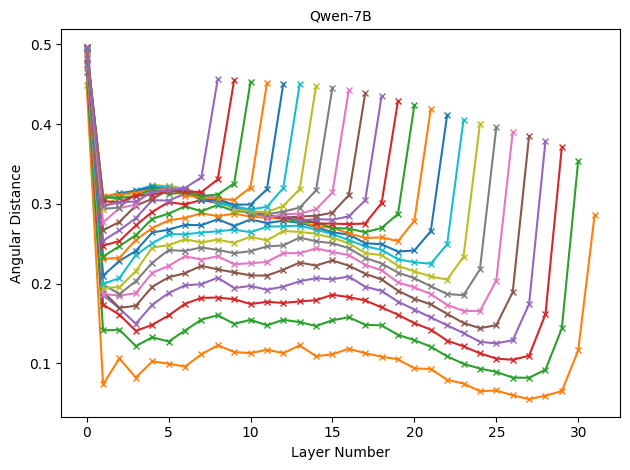

In [17]:
## cross check
import matplotlib.pyplot as plt
import numpy as np
import os

def file_reader(fname):
    if os.path.exists(fname):
        f = open(fname)
        data = json.load(f)
        last_token_sim = np.array(data)
        # print(last_token_sim.shape)
        f.close()
        return last_token_sim
    else:
        return []

step_list = np.arange(1,25)

colors = plt.cm.viridis(np.linspace(0,1,1+len(step_list)))
x_min = []
y_min = []
plt.figure()#figsize=(5,2))
for step in step_list:

    fname = f"data/c4_{model_name.split('/')[-1]}_s_{step}_check.json"
    if len(file_reader(fname))> 0:
        last_token_sim_step =  file_reader(fname)
        x = np.arange(num_layers-step+1)
        y =  np.arccos(last_token_sim_step).mean(axis=1)/np.pi
        plt.plot(x, y,"o", markersize=3,linewidth=1.5,color=f"C{step}",label=f"{step}")

    x = np.arange(num_layers-step+1)
    y =  np.arccos(np.array(last_token_sim[f"{step}"])).mean(axis=0)/np.pi
    # plt.plot(x, y,"x", markersize=4,linewidth=1.5,color=colors[step],label=f"{step}")
    idx_min = np.argmin(y)
    x_min.append(x[idx_min])
    y_min.append(y[idx_min])
    plt.plot(x, y,"x", markersize=4,linewidth=1.5,color=f"C{step}",label=f"{step}")

# plt.plot(x_min,y_min,"kx-",markersize=4,alpha=0.5)
plt.xlabel("Layer Number")# (similarity btw in and out of [x,x+1,x+2])")
plt.ylabel("Angular Distance")
plt.title(f"{model_name.split('/')[-1]}", fontsize= 10)
plt.tight_layout()
plt.show()